In [9]:
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import random
from scipy import stats, spatial

In [10]:
tfidf_path = '../../data/tfidf_toprev_conlen_full_v2/'

In [11]:
lda_path = '../../data/lda_jsd_toprev_conlen/'

In [12]:
fandom_list = [i for i in os.listdir(tfidf_path) if 'tsv' in i]

In [13]:
def bootstrap_resample(li):
    if len(li) > 0:
        ave_original = np.average(li)
        aves = []
        for i in range(1000):
            sample = []
            for i in range(len(li)):
                sample.append(random.choice(li))
            aves.append(np.average(sample))
        tail = sorted(aves)[24]
        head = sorted(aves)[975]
        return (ave_original, tail, head)

## Aggregate

In [14]:
def create_normed_dfs(df, field):

#     Normalize by log scale
    df = df.replace([np.inf, -np.inf], np.nan)
    df[field].fillna(0, inplace=True)

#     # turn into z scores
    if field == 'Comments':
        df[field] = np.log(df[field]+1)
        df = df.replace([np.inf, -np.inf], np.nan)
        df[field].dropna()
        df[field] = (df[field] - df[field].mean())/df[field].std(ddof=0)
    
    else:
        df[field] = df[field]/df['Chapters']
        df[field] = np.log(df[field]+0.001)
        df = df.replace([np.inf, -np.inf], np.nan)
        df[['Chapters',field ]].dropna()
        df[field] = (df[field] - df[field].mean())/df[field].std(ddof=0)

    return df

In [15]:
def create_dict(df, nov_field, suc_field, binsize):
    
    # Make bins
    df[nov_field] = df[nov_field].astype(float)
    vmin = min(df[nov_field].tolist())
    vmax = max(df[nov_field].tolist())
    dic = {}
    for i in np.arange(vmin, vmax, binsize):
        df_s = df[(df[nov_field] >= i) & (df[nov_field] < i+binsize)]
        li = df_s[suc_field].tolist()
        if len(li) > 0:
            dic[i] = bootstrap_resample(li)
    return dic

In [16]:
def generate_res(path, nov_field, suc_field, binsize):
    df_all = []
    fandom_list = [i for i in os.listdir(path) if 'tsv' in i]
    for i,fandom in enumerate(fandom_list):
        df = pd.read_csv(os.path.join(path,fandom), sep = '\t')
        df = create_normed_dfs(df, suc_field)
        df = df.replace([np.inf, -np.inf], np.nan)
        df = df[[nov_field, suc_field]].dropna()
        df_all.append(df)

    df = pd.concat(df_all)
    df = df.sort_values(by = nov_field)[:-5]
    df = df.sort_values(by = suc_field)[:-5]
    dic = create_dict(df, nov_field, suc_field, binsize)

    return dic
    

In [17]:
lda_kudos_dict = generate_res(lda_path, 'JSD','Kudos', 0.05)
lda_hits_dict = generate_res(lda_path, 'JSD','Hits',0.05)
lda_comments_dict = generate_res(lda_path, 'JSD','Comments',0.05)
lda_bookmarks_dict = generate_res(lda_path, 'JSD','Bookmarks',0.05)

In [18]:
import pickle

In [19]:
pickle.dump(lda_kudos_dict, open('lda_kudos_dict.p', 'wb'))
pickle.dump(lda_hits_dict, open('lda_hits_dict.p', 'wb'))
pickle.dump(lda_comments_dict, open('lda_comments_dict.p', 'wb'))
pickle.dump(lda_bookmarks_dict, open('lda_bookmarks_dict.p', 'wb'))

In [20]:
tfidf_kudos_dict = generate_res(tfidf_path, 'Cos', 'Kudos', 0.1)
tfidf_hits_dict = generate_res(tfidf_path, 'Cos', 'Hits', 0.1)
tfidf_comments_dict = generate_res(tfidf_path, 'Cos', 'Comments', 0.1)
tfidf_bookmarks_dict = generate_res(tfidf_path, 'Cos', 'Bookmarks', 0.1)

In [21]:
pickle.dump(tfidf_kudos_dict, open('tfidf_kudos_dict.p', 'wb'))
pickle.dump(tfidf_hits_dict, open('tfidf_hits_dict.p', 'wb'))
pickle.dump(tfidf_comments_dict, open('tfidf_comments_dict.p', 'wb'))
pickle.dump(tfidf_bookmarks_dict, open('tfidf_bookmarks_dict.p', 'wb'))

In [22]:
# lda_kudos_dict = pickle.load(open('lda_kudos_dict.p', 'rb'))
# lda_hits_dict = pickle.load(open('lda_hits_dict.p', 'rb'))
# lda_comments_dict = pickle.load(open('lda_comments_dict.p', 'rb'))
# lda_bookmarks_dict = pickle.load(open('lda_bookmarks_dict.p', 'rb'))

In [23]:
# tfidf_kudos_dict = pickle.load(open('tfidf_kudos_dict.p', 'rb'))
# tfidf_hits_dict = pickle.load(open('tfidf_hits_dict.p', 'rb'))
# tfidf_comments_dict = pickle.load(open('tfidf_comments_dict.p', 'rb'))
# tfidf_bookmarks_dict = pickle.load(open('tfidf_bookmarks_dict.p', 'rb'))

In [24]:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

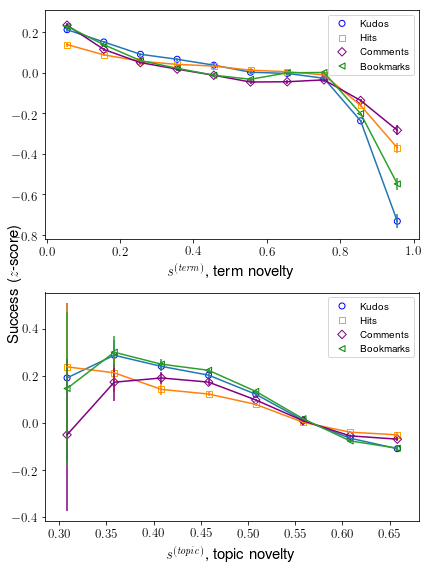

In [43]:
fig = plt.figure(figsize=(6,8))


plt.subplot(2, 1, 1)

tfidf_kudos_x = sorted(tfidf_kudos_dict.keys())
tfidf_kudos_y = [tfidf_kudos_dict[j][0] for j in tfidf_kudos_x]
lower_error = [tfidf_kudos_dict[j][0] - tfidf_kudos_dict[j][1] for j in tfidf_kudos_x]
upper_error = [tfidf_kudos_dict[j][2] - tfidf_kudos_dict[j][0] for j in tfidf_kudos_x]
asymmetric_error = [lower_error, upper_error]
plt.errorbar(tfidf_kudos_x, tfidf_kudos_y, yerr=asymmetric_error)
plt.scatter(tfidf_kudos_x, tfidf_kudos_y, label = 'Kudos',facecolor='none',edgecolor='blue')

tfidf_hits_x = sorted(tfidf_hits_dict.keys())
tfidf_hits_y = [tfidf_hits_dict[j][0] for j in tfidf_hits_x]
lower_error = [tfidf_hits_dict[j][0] - tfidf_hits_dict[j][1] for j in tfidf_hits_x]
upper_error = [tfidf_hits_dict[j][2] - tfidf_hits_dict[j][0] for j in tfidf_hits_x]
asymmetric_error = [lower_error, upper_error]
plt.errorbar(tfidf_hits_x, tfidf_hits_y, yerr=asymmetric_error)
plt.scatter(tfidf_hits_x, tfidf_hits_y,marker='s', label = 'Hits',facecolor='none',edgecolor='orange')

tfidf_comments_x = sorted(tfidf_comments_dict.keys())
tfidf_comments_y = [tfidf_comments_dict[j][0] for j in tfidf_comments_x]
lower_error = [tfidf_comments_dict[j][0] - tfidf_comments_dict[j][1] for j in tfidf_comments_x]
upper_error = [tfidf_comments_dict[j][2] - tfidf_comments_dict[j][0] for j in tfidf_comments_x]
asymmetric_error = [lower_error, upper_error]
plt.errorbar(tfidf_comments_x, tfidf_comments_y, yerr=asymmetric_error,c='purple')
plt.scatter(tfidf_comments_x, tfidf_comments_y, marker='D', label = 'Comments',facecolor='none',edgecolor='purple')

tfidf_bookmarks_x = sorted(tfidf_bookmarks_dict.keys())
tfidf_boomkarks_y = [tfidf_bookmarks_dict[j][0] for j in tfidf_bookmarks_x]
lower_error = [tfidf_bookmarks_dict[j][0] - tfidf_bookmarks_dict[j][1] for j in tfidf_bookmarks_x]
upper_error = [tfidf_bookmarks_dict[j][2] - tfidf_bookmarks_dict[j][0] for j in tfidf_bookmarks_x]
asymmetric_error = [lower_error, upper_error]
plt.errorbar(tfidf_bookmarks_x, tfidf_boomkarks_y, yerr=asymmetric_error)
plt.scatter(tfidf_bookmarks_x, tfidf_boomkarks_y, marker = '<', label = 'Bookmarks',facecolor='none',edgecolor='green')
""
plt.legend()
plt.xlabel('$\it{s}^{(term)}$, term novelty',fontsize=15)
# plt.ylabel('Success ($\it{z}$-score)',fontsize=15)
plt.tick_params(labelsize=13)

fig.text(0.03, 0.5, 'Success ($\it{z}$-score)', ha='center', va='center', rotation='vertical', fontsize=15)

plt.subplot(2, 1, 2)

# for dic in [lda_kudos_dict, lda_hits_dict, lda_comments_dict, lda_bookmarks_dict]:

lda_kudos_x = sorted(lda_kudos_dict.keys())
lda_kudos_y = [lda_kudos_dict[j][0] for j in lda_kudos_x]
lower_error = [lda_kudos_dict[j][0] - lda_kudos_dict[j][1] for j in lda_kudos_x]
upper_error = [lda_kudos_dict[j][2] - lda_kudos_dict[j][0] for j in lda_kudos_x]
asymmetric_error = [lower_error, upper_error]
plt.errorbar(lda_kudos_x, lda_kudos_y, yerr=asymmetric_error)
plt.scatter(lda_kudos_x, lda_kudos_y,label = 'Kudos',facecolor='none',edgecolor='blue')

lda_hits_x = sorted(lda_hits_dict.keys())
lda_hits_y = [lda_hits_dict[j][0] for j in lda_hits_x]
lower_error = [lda_hits_dict[j][0] - lda_hits_dict[j][1] for j in lda_hits_x]
upper_error = [lda_hits_dict[j][2] - lda_hits_dict[j][0] for j in lda_hits_x]
asymmetric_error = [lower_error, upper_error]
plt.errorbar(lda_hits_x, lda_hits_y, yerr=asymmetric_error)
plt.scatter(lda_hits_x, lda_hits_y,marker='s', label = 'Hits',facecolor='none',edgecolor='orange')

lda_comments_x = sorted(lda_comments_dict.keys())
lda_comments_y = [lda_comments_dict[j][0] for j in lda_comments_x]
lower_error = [lda_comments_dict[j][0] - lda_comments_dict[j][1] for j in lda_comments_x]
upper_error = [lda_comments_dict[j][2] - lda_comments_dict[j][0] for j in lda_comments_x]
asymmetric_error = [lower_error, upper_error]
plt.errorbar(lda_comments_x, lda_comments_y, yerr=asymmetric_error, c='purple')
plt.scatter(lda_comments_x, lda_comments_y, marker='D', label = 'Comments',facecolor='none',edgecolor='purple')

lda_bookmarks_x = sorted(lda_bookmarks_dict.keys())
lda_bookmarks_y = [lda_bookmarks_dict[j][0] for j in lda_bookmarks_x]
lower_error = [lda_bookmarks_dict[j][0] - lda_bookmarks_dict[j][1] for j in lda_bookmarks_x]
upper_error = [lda_bookmarks_dict[j][2] - lda_bookmarks_dict[j][0] for j in lda_bookmarks_x]
asymmetric_error = [lower_error, upper_error]
plt.errorbar(lda_bookmarks_x, lda_bookmarks_y, yerr=asymmetric_error )
plt.scatter(lda_bookmarks_x, lda_bookmarks_y, marker = '<', label = 'Bookmarks',facecolor='none',edgecolor='green')
plt.tick_params(labelsize=13)

plt.legend()
plt.xlabel('$\it{s}^{(topic)}$, topic novelty', fontsize = 15)
plt.tight_layout()
plt.savefig('scatter_all_log.pdf', type='pdf')
